(60000,)
(60000, 28, 28)


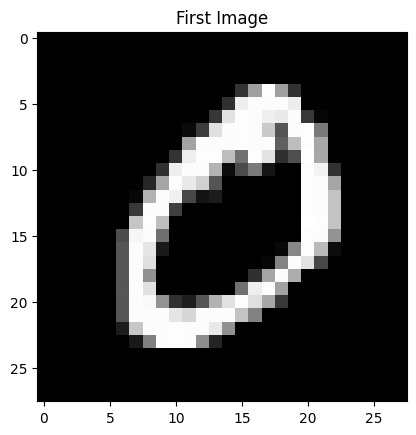

In [1]:
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
image_dim = 28

input_path = '/kaggle/input/mnist-dataset'
train_image_path = join(input_path, 'train-images.idx3-ubyte')
train_labels_path = join(input_path, 'train-labels.idx1-ubyte')
test_image_path = join(input_path, 't10k-images.idx3-ubyte')
test_labels_path = join(input_path, 't10k-labels.idx1-ubyte')

''' 
image is saved in a byte stream sequentially
first 16 for header remaining 28 * 28 pixels of each image in sequence for 60000 images
'''

with open(train_image_path, 'rb') as file: 
    data = np.frombuffer(file.read(), dtype = np.uint8)

with open(train_labels_path, 'rb') as file:
    labels = np.frombuffer(file.read(), dtype = np.uint8)
        
labels = labels[8:]
print(labels.shape)

images = data[16:].reshape(-1,image_dim, image_dim) # original size is also (28, 28)
print(images.shape)

plt.imshow(images[1], cmap="gray")
plt.title("First Image")
plt.show()

In [2]:
class MNIST_Dataloader:
    def __init__(self, train_image_path, train_labels_path, test_image_path, test_labels_path, dim):
        """
        Initialize the MNIST dataloader.
        :param train_image_path: Path to the training images.
        :param train_labels_path: Path to the training labels.
        :param test_image_path: Path to the test images.
        :param test_labels_path: Path to the test labels.
        :param dim: Dimension of the images (e.g., 28 for 28x28 images).
        :param preprocessors: List of preprocessing functions to apply to the images.
        """
        self.train_image_path = train_image_path
        self.train_labels_path = train_labels_path
        self.test_image_path = test_image_path
        self.test_labels_path = test_labels_path
        self.dim = dim

    def read_image_labels(self, image_path, label_path):
        with open(image_path, 'rb') as file:
            images = np.frombuffer(file.read(), dtype=np.uint8)

        # Reshape and normalize images
        images = images[16:].reshape(-1, self.dim, self.dim).astype(np.float32)
        images /= 255.0  # Normalize to range [0, 1]

        with open(label_path, 'rb') as file:
            labels = np.frombuffer(file.read(), dtype=np.uint8)

        # One-hot encode labels
        one_hot_labels = np.eye(10)[labels[8:]]

        return images, one_hot_labels

    def load_data(self):
        """
        Load the MNIST data.
        :return: Tuple containing train and test datasets.
        """
        train_images, train_labels = self.read_image_labels(self.train_image_path, self.train_labels_path)
        test_images, test_labels = self.read_image_labels(self.test_image_path, self.test_labels_path)

        # Flatten images back to 1D after preprocessing
        train_images = train_images.reshape(-1, self.dim**2)
        test_images = test_images.reshape(-1, self.dim**2)

        return (train_images, train_labels), (test_images, test_labels)


dobj = MNIST_Dataloader(train_image_path, train_labels_path, test_image_path, test_labels_path, image_dim)

(train_images, train_labels), (test_images, test_labels) = dobj.load_data()
split_ratio = 0.2
split_index = int(len(train_images) * split_ratio)
train_images, train_labels = train_images[split_index:], train_labels[split_index:]
val_images, val_labels = train_images[:split_index], train_labels[:split_index]

print(train_images.shape, train_labels.shape)
print(val_images.shape, val_labels.shape)
print(test_images.shape, test_labels.shape)

(48000, 784) (48000, 10)
(12000, 784) (12000, 10)
(10000, 784) (10000, 10)


In [3]:
class FullyConnectedNN:
    def __init__(self, layers):
        self.layers = layers
        self.weights = []
        self.biases = []
        self.best_loss = float('inf')  # Initialize with a high value
        
        # Initialize weights and biases using He initialization
        for i in range(len(layers) - 1):
            self.weights.append(np.random.randn(layers[i], layers[i + 1]) * np.sqrt(2 / layers[i]))
            self.biases.append(np.zeros((1, layers[i + 1])))

    def relu(self, z):
        return np.maximum(0, z)

    def relu_derivative(self, z):
        return np.where(z > 0, 1, 0)

    def softmax(self, z):
        # Check for NaN or Inf in z before applying softmax
        if np.any(np.isnan(z)) or np.any(np.isinf(z)):
            print("Warning: NaN or Inf detected in z before softmax.")
        z_stable = z - np.max(z, axis=1, keepdims=True)  # Stability improvement
        exp_z = np.exp(z_stable)
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def feedforward(self, X, training=True):
        activations = [X]
        for i in range(len(self.weights)):
            z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            if i == len(self.weights) - 1:  # Output layer
                a = self.softmax(z)
            else:  # Hidden layers
                a = self.relu(z)
            activations.append(a)
        return activations

    def backpropagation(self, X, y, learning_rate):
        activations = self.feedforward(X, training=True)
        deltas = [activations[-1] - y]

        for i in range(len(self.layers) - 2, 0, -1):
            delta = np.dot(deltas[-1], self.weights[i].T)
            delta *= self.relu_derivative(activations[i])
            deltas.append(delta)

        deltas.reverse()

        for i in range(len(self.weights)):
            # Update weights and biases with gradient clipping
            grad_w = np.dot(activations[i].T, deltas[i])
            grad_b = np.sum(deltas[i], axis=0, keepdims=True)
            grad_w = np.clip(grad_w, -2.0, 2.0)  # Clip gradients to prevent explosion
            grad_b = np.clip(grad_b, -2.0, 2.0)
            self.weights[i] -= learning_rate * grad_w
            self.biases[i] -= learning_rate * grad_b

    def train(self, X, y, X_val, y_val, epochs, learning_rate):
        for epoch in range(epochs):
            self.backpropagation(X, y, learning_rate)
            train_loss = self.calculate_loss(X, y)
            val_loss = self.calculate_loss(X_val, y_val)
            accuracy = self.calculate_accuracy(X_val, y_val)

            # Save the best weights based on validation loss
            if val_loss < self.best_loss:
                self.best_loss = val_loss
                best_weights = [w.copy() for w in self.weights]
                best_biases = [b.copy() for b in self.biases]
                print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}")
                self.save_best_weights('best_weights.npy', best_weights, best_biases)

            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}")

    def predict(self, X):
        return self.feedforward(X, training=False)[-1]

    def calculate_loss(self, X, y):
        predictions = self.predict(X)
        # Add epsilon to avoid log(0)
        return -np.mean(np.sum(y * np.log(predictions + 1e-8), axis=1))

    def calculate_accuracy(self, X, y):
        predictions = self.predict(X)
        predicted_labels = np.argmax(predictions, axis=1)
        true_labels = np.argmax(y, axis=1)
        return np.mean(predicted_labels == true_labels)

    def save_best_weights(self, filepath, best_weights, best_biases):
        np.save(filepath, {'weights': best_weights, 'biases': best_biases})
        print("Best weights saved to disk.")

    def load_weights(self, filepath):
        data = np.load(filepath, allow_pickle=True).item()
        self.weights = data['weights']
        self.biases = data['biases']
        print("Best weights loaded from disk.")

In [5]:
# Define network structure: 784 input neurons, 1 hidden layers with 128 neurons each, and 10 output neuron
layers = [image_dim ** 2, 256, 128, 10]

# Calculate the number of trainable parameters in the network
params = 0
for i in range(len(layers) - 1): 
    if i == 0:
        params += layers[i] * image_dim ** 2
    else:
        params += layers[i] * layers[i - 1]

print("Total trainable parameters:", params)

# Create the neural network
nn = FullyConnectedNN(layers)

# Train the network (use train_images and train_labels)
nn.train(train_images, train_labels, val_images, val_labels, epochs=400, learning_rate=0.005)


Total trainable parameters: 848128
Epoch 0, Train Loss: 1.7760, Val Loss: 1.8006, Accuracy: 0.4602
Best weights saved to disk.
Epoch 0, Train Loss: 1.7760, Val Loss: 1.8006, Accuracy: 0.4602
Epoch 7, Train Loss: 1.3428, Val Loss: 1.3587, Accuracy: 0.5678
Best weights saved to disk.
Epoch 9, Train Loss: 1.2905, Val Loss: 1.3029, Accuracy: 0.6654
Best weights saved to disk.
Epoch 11, Train Loss: 1.0047, Val Loss: 1.0035, Accuracy: 0.6786
Best weights saved to disk.
Epoch 13, Train Loss: 1.0055, Val Loss: 0.9993, Accuracy: 0.6877
Best weights saved to disk.
Epoch 23, Train Loss: 0.9911, Val Loss: 0.9840, Accuracy: 0.7436
Best weights saved to disk.
Epoch 25, Train Loss: 0.9649, Val Loss: 0.9642, Accuracy: 0.7652
Best weights saved to disk.
Epoch 38, Train Loss: 0.9161, Val Loss: 0.9208, Accuracy: 0.7733
Best weights saved to disk.
Epoch 40, Train Loss: 0.8554, Val Loss: 0.8616, Accuracy: 0.7891
Best weights saved to disk.
Epoch 42, Train Loss: 0.8284, Val Loss: 0.8282, Accuracy: 0.7950
Be

In [6]:
nn.load_weights('best_weights.npy')
accuracy = nn.calculate_accuracy(test_images, test_labels)
loss = nn.calculate_loss(test_images, test_labels)

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {loss}")

Best weights loaded from disk.
Test Accuracy: 92.81%
Test Loss: 0.5028302131428092
